In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from math import *
import qutip as qt
import qutip.qip
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

# static image plots
%matplotlib inline
# interactive 3D plots
# %matplotlib widget

In [2]:
def photon_count_distribution(state: qt.Qobj):
    """
    Returns the photon number distribution P(n) for any state.
    """
    if state.isket:
        # For Kets: |Amplitude|^2
        # We flatten it to get a 1D array
        return np.abs(state.full().flatten())**2
    else:
        # For Density Matrices: Extract the diagonal
        # We take .real to discard any +0j imaginary artifacts
        return np.real(state.diag())

In [3]:
def join_modes(mode1: qt.Qobj, mode2: qt.Qobj) -> qt.Qobj:
    """Merges two independent modes into a joint Hilbert space (tensor product)."""
    return qt.tensor(mode1, mode2)

def separate_modes(joint_state: qt.Qobj):
    """
    Takes a joint state (2 modes) and returns the reduced density matrices 
    for mode 1 and mode 2 respectively (Partial Trace).
    """
    # Verify the state has two subsystems
    if len(joint_state.dims[0]) != 2:
        raise ValueError("State does not appear to be a 2-mode system.")
        
    return joint_state.ptrace(0), joint_state.ptrace(1)

def beamsplitter_general(input_state: qt.Qobj, input_2: qt.Qobj = None, transmissivity: float = 0.5) -> qt.Qobj:
    """
    Applies a beamsplitter interaction.
    
    Args:
        input_state: Either a joint state (2 modes) OR the state for Mode 1.
        input_2: (Optional) If input_state is Mode 1, this must be Mode 2.
        transmissivity: Probability of swapping modes (0 to 1).
                        T=0 is Identity, T=1 is full Swap, T=0.5 is 50:50.
    
    Returns:
        The evolved joint state (Ket or Density Matrix).
    """
    
    # 1. Standardize Input: Ensure we have one Joint State
    if input_2 is not None:
        # Case A: User provided two separate modes -> Tensor them
        state = qutip.tensor(input_state, input_2)
    else:
        # Case B: User provided a pre-existing joint state
        state = input_state
        # Validation: Ensure it actually has 2 modes
        if len(state.dims[0]) != 2:
            raise ValueError("Input provided is not a joint 2-mode system (dims must imply tensor structure).")

    # 2. Extract Dimensions
    # state.dims looks like [[N1, N2], [N1, N2]] for density matrices
    # or [[N1, N2], [1, 1]] for kets.
    # We grab the first list to get the Hilbert space sizes.
    N1 = state.dims[0][0]
    N2 = state.dims[0][1]

    if N1 != N2:
        # While physically possible, usually in simulation we keep cutoff dims identical
        # to allow swapping without dimension mismatch errors.
        raise ValueError(f"Mode dimensions mismatch: {N1} vs {N2}")
    
    N = N1

    # 3. Define Operators on the Joint Space
    a = qt.destroy(N)
    
    # a1 acts on first subspace, identity on second
    a1 = qt.tensor(a, qt.qeye(N))
    # a2 acts on identity on first, normal on second
    a2 = qt.tensor(qt.qeye(N), a)

    # 4. mixing angle theta
    # Transmissivity T = sin^2(theta)
    theta = np.arcsin(np.sqrt(transmissivity))

    # 5. Beamsplitter Unitary
    # U = exp( theta * (a1^dag a2 - a1 a2^dag) )
    generator = theta * (a1.dag() * a2 - a1 * a2.dag())
    U_bs = generator.expm()

    # 6. Apply Unitary
    if state.isket:
        return U_bs * state
    else:
        return U_bs * state * U_bs.dag()


def apply_loss_channel(input_qumode: qt.Qobj, trasmissivity: float):
    N_input = input_qumode.shape[0]
    vacuum = qt.basis(N_input, 0)
    output_qumode, _ = separate_modes(beamsplitter_general(input_qumode, vacuum, 1-trasmissivity))
    return output_qumode

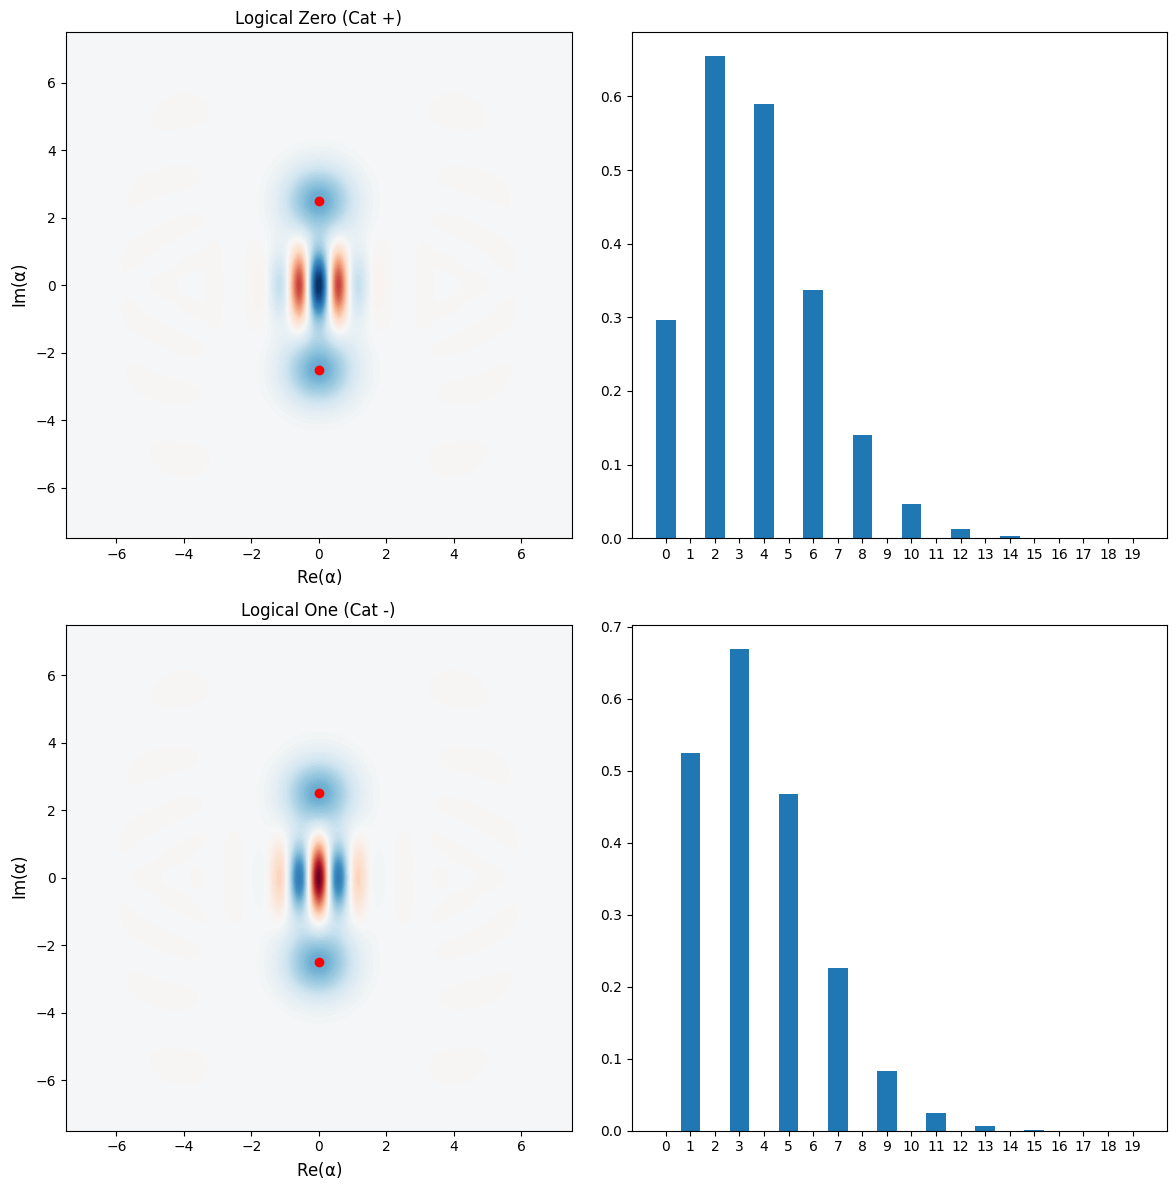

In [18]:
N = 20
vacuum = qt.basis(N, 0)

vertical_displacement = 2.5


alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qt.displace(N, alpha_coeff)
negative_displacement_operator = qt.displace(N, -alpha_coeff)


plus_alpha_state = positive_displacement_operator * vacuum
minus_alpha_state = negative_displacement_operator * vacuum

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()


fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(logical_zero, ax=axes[0, 0])
axes[0, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0, 0].set_title("Logical Zero (Cat +)")
qt.plot_wigner(logical_one, ax=axes[1, 0])
axes[1, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[1, 0].set_title("Logical One (Cat -)")


axes[0, 1].bar(np.arange(N), np.abs(logical_zero.full()).flatten())
axes[0, 1].set_xticks(np.arange(N))
axes[0, 1].set_aspect('auto')
axes[1, 1].bar(np.arange(N), np.abs(logical_one.full()).flatten())
axes[1, 1].set_xticks(np.arange(N))
axes[1, 1].set_aspect('auto')

plt.tight_layout()
plt.show()

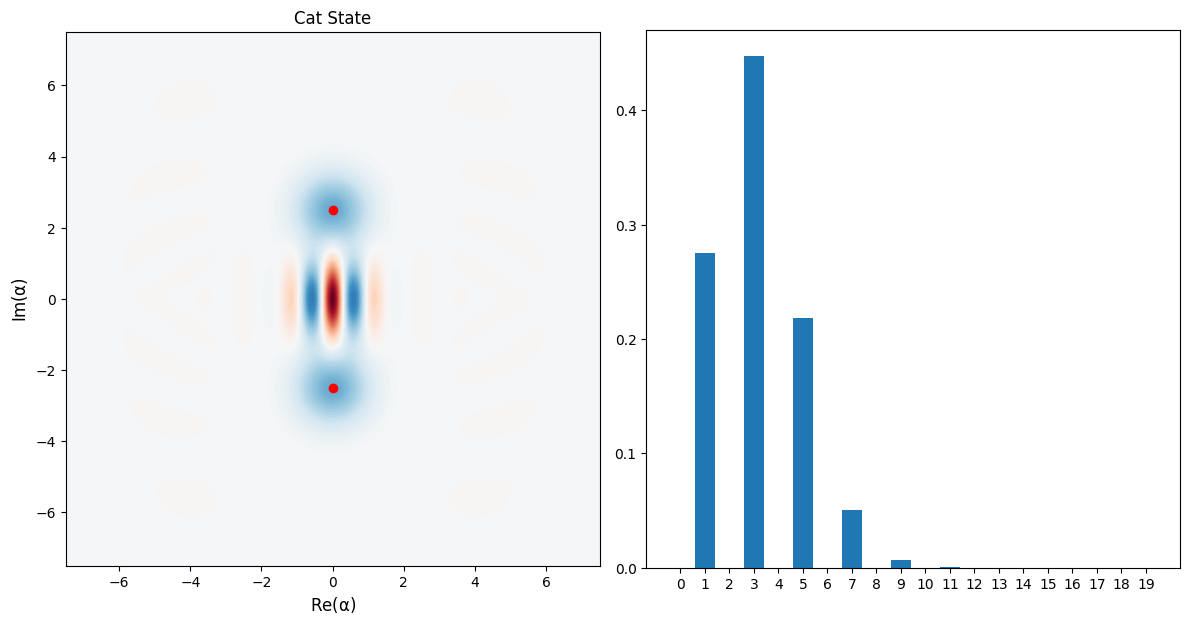

In [ ]:
N = 20

H_I = qt.tensor(qutip.gates.snot(), qt.qeye(2))
CNOT = qt.gates.cnot()
tx_side_qubits = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
tx_side_qubits = H_I * tx_side_qubits
tx_side_qubits = CNOT * tx_side_qubits

tx_side_vacuum = qt.basis(N, 0)

dv_tensor_cv = qt.tensor(tx_side_qubits, tx_side_vacuum)


alpha = 2.5 * sqrt(2)  # The amplitude of the cat state




vacuum = qt.basis(N, 0)

vertical_displacement = 2.5


alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qt.displace(N, alpha_coeff)
negative_displacement_operator = qt.displace(N, -alpha_coeff)


plus_alpha_state = positive_displacement_operator * vacuum
minus_alpha_state = negative_displacement_operator * vacuum

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()



# 2. Lift these operators to the full 3-subsystem Hilbert space
# System order: [Qubit 0, Qubit 1, Oscillator]
# We want the gate to trigger based on Qubit 1 (index 1)
identity_q0 = qt.qeye(2)

# Create the Controlled-Displacement 
# This applies D_pos if Qubit 1 is |0> and D_neg if Qubit 1 is |1>
U_encode = (qt.tensor(identity_q0, qt.basis(2, 0).proj(), logical_zero * qt.basis(N, 0).dag()) + 
            qt.tensor(identity_q0, qt.basis(2, 1).proj(), logical_one * qt.basis(N, 0).dag()))

# 3. Apply the encoding to your existing tensor state
final_state = U_encode * dv_tensor_cv



# Projector for Qubit 0 onto the |1> state
proj_q0_zero = qt.tensor(qt.basis(2, 0).proj(), qt.qeye(2), qt.qeye(N))
proj_q0_one = qt.tensor(qt.basis(2, 1).proj(), qt.qeye(2), qt.qeye(N))

# Apply measurement and re-normalize
collapsed_state = (proj_q0_zero * final_state).unit()

# Extract the CV mode (index 2)
rho_cv = collapsed_state.ptrace(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(rho_cv, ax=axes[0])
axes[0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0].set_title("Cat State")


axes[1].bar(np.arange(N), photon_count_distribution(rho_cv))
axes[1].set_xticks(np.arange(N))
axes[1].set_aspect('auto')

plt.tight_layout()
plt.show()